In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords

## Intro to word2vec

The most common unsupervised neural network approach for NLP is word2vec, a shallow neural network model for converting words to vectors using distributed representation: Each word is represented by many neurons, and each neuron is involved in representing many words.  At the highest level of abstraction, word2vec assigns a vector of random values to each word.  For a word W, it looks at the words that are near W in the sentence, and shifts the values in the word vectors such that the vectors for words near that W are closer to the W vector, and vectors for words not near W are farther away from the W vector.  With a large enough corpus, this will eventually result in words that often appear together having vectors that are near one another, and words that rarely or never appear together having vectors that are far away from each other.  Then, using the vectors, similarity scores can be computed for each pair of words by taking the cosine of the vectors.  

This may sound quite similar to the Latent Semantic Analysis approach you just learned.  The conceptual difference is that LSA creates vector representations of sentences based on the words in them, while word2vec creates representations of individual words, based on the words around them.

## What is it good for?

Word2vec is useful for any time when computers need to parse requests written by humans. The problem with human communication is that there are so many different ways to communicate the same concept. It's easy for us, as humans, to know that "the silverware" and "the utensils" can refer to the same thing. Computers can't do that unless we teach them, and this can be a real chokepoint for human/computer interactions. If you've ever played a text adventure game (think _Colossal Cave Adventure_ or _Zork_), you may have encountered the following scenario:

And your brain explodes from frustration. A text adventure game that incorporates a properly trained word2vec model would have vectors for "pick up", "lift", and "take" that are close to the vector for "grab" and therefore could accept those other verbs as synonyms so you could move ahead faster. In more practical applications, word2vec and other similar algorithms are what help a search engine return the best results for your query and not just the ones that contain the exact words you used. In fact, search is a better example, because not only does the search engine need to understand your request, it also needs to match it to web pages that were _also written by humans_ and therefore _also use idiosyncratic language_.

Humans, man.  

So how does it work?

## Generating vectors: Multiple algorithms

In considering the relationship between a word and its surrounding words, word2vec has two options that are the inverse of one another:

 * _Continuous Bag of Words_ (CBOW): the identity of a word is predicted using the words near it in a sentence.
 * _Skip-gram_: The identities of words are predicted from the word they surround. Skip-gram seems to work better for larger corpuses.

For the sentence "Terry Gilliam is a better comedian than a director", if we focus on the word "comedian" then CBOW will try to predict "comedian" using "is", "a", "better", "than", "a", and "director".  Skip-gram will try to predict "is", "a", "better", "than", "a", and "director" using the word "comedian". In practice, for CBOW the vector for "comedian" will be pulled closer to the other words, while for skip-gram the vectors for the other words will be pulled closer to "comedian".  

In addition to moving the vectors for nearby words closer together, each time a word is processed some vectors are moved farther away. Word2vec has two approaches to "pushing" vectors apart:
 
 * _Negative sampling_: Like it says on the tin, each time a word is pulled toward some neighbors, the vectors for a randomly chosen small set of other words are pushed away.
 * _Hierarchical softmax_: Every neighboring word is pulled closer or farther from a subset of words chosen based on a tree of probabilities.

## What is similarity? Word2vec strengths and weaknesses

Keep in mind that word2vec operates on the assumption that frequent proximity indicates similarity, but words can be "similar" in various ways. They may be conceptually similar ("royal", "king", and "throne"), but they may also be functionally similar ("tremendous" and "negligible" are both common modifiers of "size"). Here is a more detailed exploration, [with examples](https://quomodocumque.wordpress.com/2016/01/15/messing-around-with-word2vec/), of what "similarity" means in word2vec.

One cool thing about word2vec is that it can identify similarities between words _that never occur near one another in the corpus_. For example, consider these sentences:

"The dog played with an elastic ball."
"Babies prefer the ball that is bouncy."
"I wanted to find a ball that's elastic."
"Tracy threw a bouncy ball."

"Elastic" and "bouncy" are similar in meaning in the text but don't appear in the same sentence. However, both appear near "ball". In the process of nudging the vectors around so that "elastic" and "bouncy" are both near the vector for "ball", the words also become nearer to one another and their similarity can be detected.

For a while after it was introduced, [no one was really sure why word2vec worked as well as it did](https://arxiv.org/pdf/1402.3722v1.pdf) (see last paragraph of the linked paper). A few years later, some additional math was developed to explain word2vec and similar models. If you are comfortable with both math and "academese", have a lot of time on your hands, and want to take a deep dive into the inner workings of word2vec, [check out this paper](https://arxiv.org/pdf/1502.03520v7.pdf) from 2016.  

One of the draws of word2vec when it first came out was that the vectors could be used to convert analogies ("king" is to "queen" as "man" is to "woman", for example) into mathematical expressions ("king" + "woman" - "man" = ?) and solve for the missing element ("queen"). This is kinda nifty.

A drawback of word2vec is that it works best with a corpus that is at least several billion words long. Even though the word2vec algorithm is speedy, this is a a lot of data and takes a long time! Our example dataset is only two million words long, which allows us to run it in the notebook without overwhelming the kernel, but probably won't give great results.  Still, let's try it!

There are a few word2vec implementations in Python, but the general consensus is the easiest one to us is in [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Now is a good time to `pip install gensim` if you don't have it yet.

In [6]:
# Utility function to clean text.
def text_cleaner(text):
    
    # Visual inspection shows spaCy does not recognize the double dash '--'.
    # Better get rid of it now!
    text = re.sub(r'--',' ',text)
    
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of chapter titles.
    text = re.sub(r'Chapter \d+','',text)
    
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    
    return text[0:900000]


# Import all the Austen in the Project Gutenberg corpus.
austen = ""
for novel in ['persuasion','emma','sense']:
    work = gutenberg.raw('austen-' + novel + '.txt')
    austen = austen + work

# Clean the data.
austen_clean = text_cleaner(austen)

In [7]:
# Parse the data. This can take some time.
nlp = spacy.load('en')
austen_doc = nlp(austen_clean)

In [8]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
sentences = []
for sentence in austen_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    sentences.append(sentence)


print(sentences[20])
print('We have {} sentences and {} tokens.'.format(len(sentences), len(austen_clean)))

['lady', 'russell', 'steady', 'age', 'character', 'extremely', 'provide', 'thought', 'second', 'marriage', 'need', 'apology', 'public', 'apt', 'unreasonably', 'discontent', 'woman', 'marry', 'sir', 'walter', 'continue', 'singleness', 'require', 'explanation']
We have 9298 sentences and 900000 tokens.


In [9]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    sentences,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [10]:
# List of words in model.
vocab = model.wv.vocab.keys()

print(model.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('mr', 'mrs'))

# One of these things is not like the other...
print(model.doesnt_match("breakfast marriage dinner lunch".split()))

[('goddard', 0.9596381187438965), ('musgrove', 0.9450072050094604), ('clay', 0.943478524684906), ('harville', 0.9415040016174316), ('croft', 0.9242750406265259), ('benwick', 0.9175589680671692), ('smith', 0.8972528576850891), ('wentworth', 0.8955861926078796), ('weston', 0.8852471709251404), ('hall', 0.8835679292678833)]
0.9035416


C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  # This is added back by InteractiveShellApp.init_path()


dinner


Clearly this model is not great – while some words given above might possibly fill in the analogy woman:lady::man:?, most answers likely make little sense. You'll notice as well that re-running the model likely gives you different results, indicating random chance plays a large role here.

We do, however, get a nice result on "marriage" being dissimilar to "breakfast", "lunch", and "dinner". 

## Drill 0

Take a few minutes to modify the hyperparameters of this model and see how its answers change. Can you wrangle any improvements?

In [12]:
# Tinker with hyperparameters here.
model2 = word2vec.Word2Vec(
    sentences,
    workers=8,     # My computer actually has 8 threads, so I'll use all of them to cut down on processing time.
    min_count=10,  # Minimum word count threshold.
    window=9,      # I figure plenty of sentences are more then 6 words, so I'll up this parameter a bit..
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=600,      # Let's see what happens if I increase the size of the vectors
    hs=1,           # Use hierarchical softmax.
    alpha=1, 
    min_alpha=.25 # I figure changing the learning rate would be the first things I do. 
)

print('done!')
# List of words in model.
vocab = model2.wv.vocab.keys()

print(model2.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model2.wv.similarity('mr', 'mrs'))

# One of these things is not like the other...
print(model2.doesnt_match("breakfast marriage dinner lunch".split()))



done!
[('recover', 0.9788128137588501), ('involve', 0.9739043712615967), ('require', 0.9644990563392639), ('fortune', 0.9622564315795898), ('happen', 0.9477120637893677), ('office', 0.9467321634292603), ('result', 0.9452999830245972), ('pleasantly', 0.9323749542236328), ('public', 0.9190963506698608), ('endeavour', 0.91778564453125)]
0.5180602


C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).


marriage


Hey that looks a bit better. The most helpful bit was increasing the size of the word vector. 

# Example word2vec applications

You can use the vectors from word2vec as features in other models, or try to gain insight from the vector compositions themselves.

Here are some neat things people have done with word2vec:

 * [Visualizing word embeddings in Jane Austen's Pride and Prejudice](http://blogger.ghostweather.com/2014/11/visualizing-word-embeddings-in-pride.html). Skip to the bottom to see a _truly honest_ account of this data scientist's process.

 * [Tracking changes in Dutch Newspapers' associations with words like 'propaganda' and 'alien' from 1950 to 1990](https://www.slideshare.net/MelvinWevers/concepts-through-time-tracing-concepts-in-dutch-newspaper-discourse-using-sequential-word-vector-spaces).

 * [Helping customers find clothing items similar to a given item but differing on one or more characteristics](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/).

## Drill 1: Word2Vec on 100B+ words

As we mentioned, word2vec really works best on a big corpus, but it can take half a day to clean such a corpus and run word2vec on it.  Fortunately, there are word2vec models available that have already been trained on _really_ big corpora. They are big files, but you can download a [pretrained model of your choice here](https://github.com/3Top/word2vec-api). At minimum, the ones built with word2vec (check the "Architecture" column) should load smoothly using an appropriately modified version of the code below, and you can play to your heart's content.

Because the models are so large, however, you may run into memory problems or crash the kernel. If you can't get a pretrained model to run locally, check out this [interactive web app of the Google News model](https://rare-technologies.com/word2vec-tutorial/#bonus_app) instead.

However you access it, play around with a pretrained model. Is there anything interesting you're able to pull out about analogies, similar words, or words that don't match? Write up a quick note about your tinkering and discuss it with your mentor during your next session.

In [13]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format ('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

KeyboardInterrupt: 

So I couldn't run it. I just used the google page. It worked ok. I'll try to post some of my results here. I'll try to appropriately save and capture the experiments with the NLP process. 

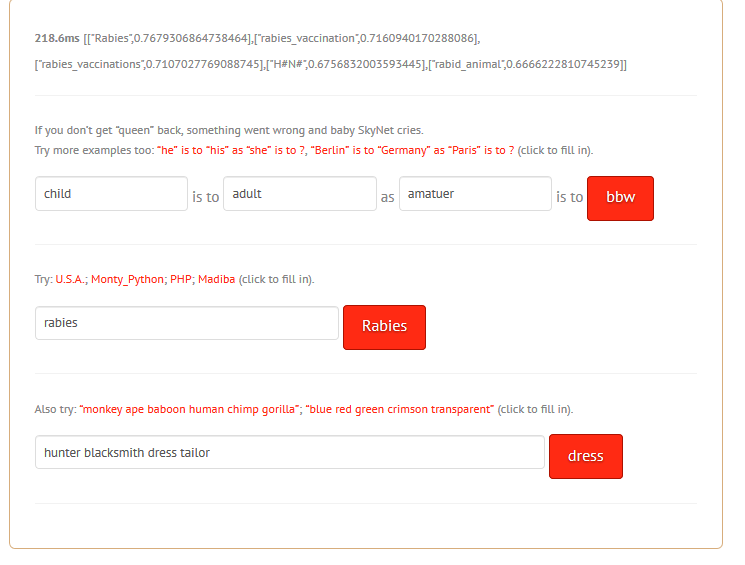

In [3]:
from IPython.display import Image
Image(r"C:\Users\Ebel\Pictures\Experiment1.png")

So a couple issues are present. With the first example, I was thinking in terms of development, a child develops into an adult, an amatuer develops into a professional, or master, or some other equivalent phrase. I had to google what a "BBW" is, I won't really clarify what I found, other than it isn't really fitting for neither the comparison, nor an academic notebook. 

The second similariy caused problems, a very obvious one. Namely, that if given a capitalized or non-capitalized word, it'll give you the other version. Technically it's correct, but it isn't as usefull as other options. Fortunately, the ouput also includes other options put forward. However, other issues come up there. There's a very big different betweeen administering "rabies" and administering "rabies vaccination." Probably the best comparison would be a "rabid animal" in that it is related to rabies. A word that I might have expected was something genericized like "disease" or "sickness." It seems that it doesn't look for similarities in usage, but similarities in where it might come up. Like it's likely to hear about a rabies vaccine in the same content you would find rabies. 

I gave it a pretty basic one, it did fine. No comment. I'll give it harder one next roll. 

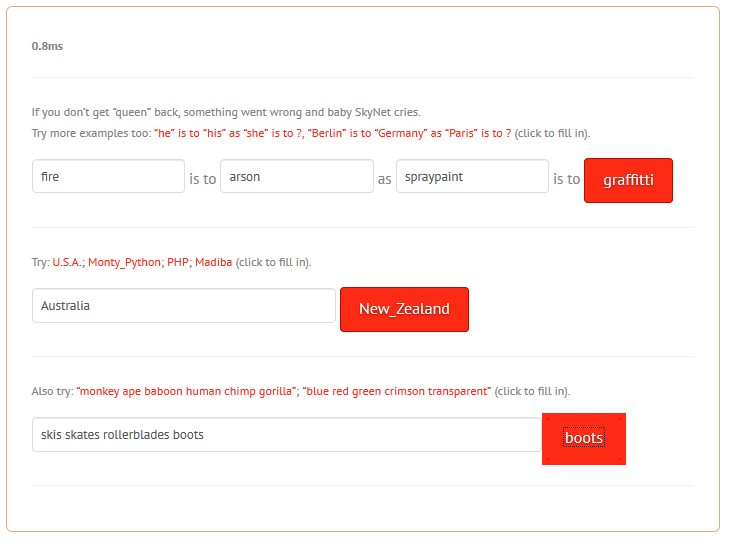

In [13]:
Image(r"C:\Users\Ebel\Pictures\Experiment2.png")

I was actually pretty impressed with the first one. That's something that might take a second for a normal person to think out, and the computer managed to figure out a complex relationship like "this is involved in X in the terms of crime." I expected it to give me something more like "paint" or "color." But it seems to have picked up on the relationship relatively easily. 

The relationship to Australia is interesting, it seems to have picked up on the closest country geographically. I'll see if that trend caries through to other locations. 

Tis one I figured was a bit harder. They all get put on a persons feet right? But only one doesn't assist movement. That said, I think most people could solve that in half a second, so I think for my third experiment I'll give it a set of three that could be interpreted in multiple ways. 

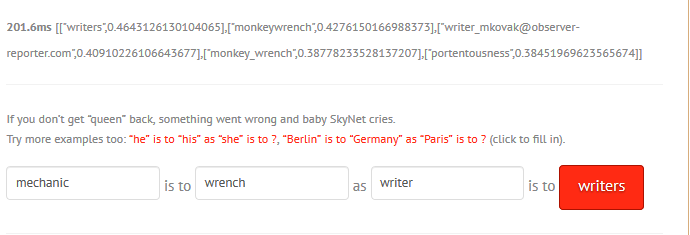

In [14]:
Image(r"C:\Users\Ebel\Pictures\Experiment3.png")

I was aiming for pen but... clearly a bit much to ask for. I guess "abstract tool of trade" is going a bit far. I do find it funny that a specific gmail account of a reporter came up enough to be associated with the word, as is the term "portentousness." I suppose, in a way, many do use the attribute of being portentous as a tool of their trade. 

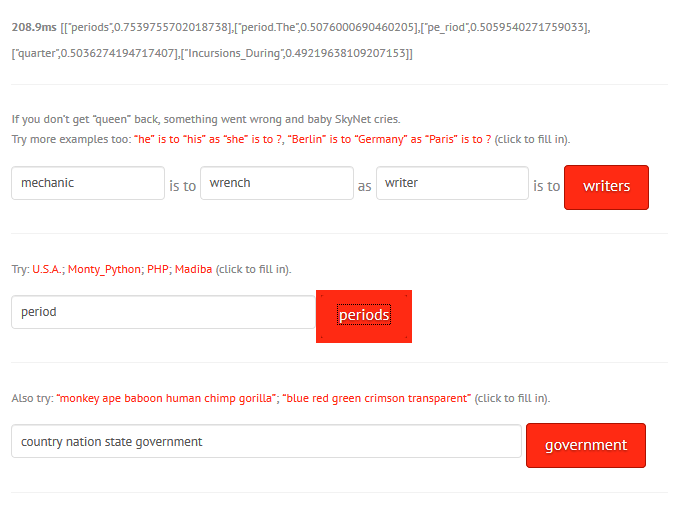

In [15]:
Image(r"C:\Users\Ebel\Pictures\Experiment4.png")

None of the second set really worked well for me. Periods is a pluralizations, yet another thing to worry about, and then the following is some fairly strange stuff. "period.The" is evidently a phrase that can be associated as well as "pe_roid" which seems like it must be grammatical error. The two other options are more fitting for the actual similarity. A quarter is a period of time, so.... passable. "incursions_during" are a phrase I might expect in content around history, where I would also expect to find the term "period" in reference to "time period." If I were to be honest, I wasn't sure what I was expecting from "period" either something in the category of punctuation, or "end." It seems the most frequent context in which a word is used is more important then anything else with similar usage, in terms of the usage of the porgram. 

This one I gave it something a bit trickier. A all of these phrases would be used in similar contexts, but with more subtle differences in implication. Country, is in a sense, a geographical area, a nation is a group of people within that area, a goverment is a system of organizations that tends to regulate the previous two, a state is an assembly of all three together. Truthfully, you could argue for multiple correct answers here. But the key to how word2vec interprets words is not their definition, but their usuage. The state is a more of an abstract concept, as is nation, although their distinctly used, and country is a fairly discrete geographic unit, government tends to be used in a concrete systematic deliniation, which I guess is what word2vec picked up on.

I think I have picked up on what it means to discern words based on context, and both the limitations and potential of that model. 